<a href="https://colab.research.google.com/github/Ddddzq/Tree-Species-Identification-Model/blob/main/2500samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="float:left">
    <h1 style="width:800px">Tree Species Identification Using Multi-Modal Deep Learning: Combining Camden Tree Map and Google Street View Imagery</h1>
    <h3 style="width:600px">CASA0004: Dissertation</h3>
    <h3 style="width:600px">Author: Zuqi Dong</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

*This is the Dissertstion for the Master Degree of UCL CASA Urban Spatial Analysis*
<br>
**Code and Data is hosted [here](https://github.com/Ddddzq/Tree-Species-Identification-Model)**<br>


# Import and install libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
# For TensorFlow
import tensorflow as tf
print(tf.__version__)

# For Keras
import keras
print(keras.__version__)


2.12.0
2.12.0


In [3]:
!pip install geopandas
!pip install xgboost

In [4]:
import xgboost as xgb

# Data
The original data is from Camden Council
[Tree Map](https://opendata.camden.gov.uk/Environment/Trees-In-Camden-Map/p5w8-cdre)
The verision used in this research is from 2023-03-18

> In this project we need the csv file from Camden Council as the structured data [Trees_In_Camden](https://github.com/Ddddzq/Tree-Species-Identification-Model/blob/main/Trees_In_Camden.csv) for XGBoost modelling


> Construction of image dataset using Camden's dataset for Resnet50 modelling





In [5]:
# Get access to csv file in github
import requests
import pandas as pd
from io import StringIO

url = 'https://raw.githubusercontent.com/Ddddzq/Tree-Species-Identification-Model/main/Trees_In_Camden.csv'
response = requests.get(url)

if response.status_code == 200:
    data = StringIO(response.text)
    camden_tree = pd.read_csv(data)
else:
    print("Failed to fetch the file.")

In [6]:
camden_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24479 entries, 0 to 24478
Data columns (total 34 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Number Of Trees                                   24472 non-null  float64
 1   Sequence                                          24479 non-null  object 
 2   Site Name                                         24479 non-null  object 
 3   Contract Area                                     24479 non-null  object 
 4   Scientific Name                                   24479 non-null  object 
 5   Common Name                                       24225 non-null  object 
 6   Inspection Date                                   23575 non-null  object 
 7   Inspection Due Date                               23575 non-null  object 
 8   Height In Metres                                  24082 non-null  float64
 9   Spread In Metres 

## *Data preprocessing*

In [7]:
# only keep the useful columns
camden_tree = camden_tree[['Contract Area','Number Of Trees','Scientific Name','Common Name','Height In Metres','Spread In Metres','Diameter In Centimetres At Breast Height'
,'Maturity','Longitude','Latitude','Location']]

In [8]:
# filter rows where each row represents a certain tree
camden_tree = camden_tree[camden_tree['Number Of Trees']==1]
camden_tree_clean = camden_tree.dropna()

# drop rows where 'Height In Metres' or 'Diameter In Centimetres At Breast Height' is 0
camden_tree_clean = camden_tree_clean[(camden_tree_clean['Height In Metres'] != 0) & (camden_tree_clean['Diameter In Centimetres At Breast Height'] != 0)
& (camden_tree_clean['Spread In Metres'] != 0)]

# drop rows where 'Maturity' is 'Not Applicable'
camden_tree_clean= camden_tree_clean[camden_tree_clean['Maturity'] != 'Not Applicable']

camden_tree_clean.head(10)

,Contract Area,Number Of Trees,Scientific Name,Common Name,Height In Metres,Spread In Metres,Diameter In Centimetres At Breast Height,Maturity,Longitude,Latitude,Location
1,Highways,1.0,Ulmus Fiorente,Elm -Hybrid,4.0,2.0,4.0,Young,-0.118898,51.523624,"(51.523624, -0.118898)"
4,Housing,1.0,Ulmus dodoens,Elm - Dodoens,4.0,1.0,6.0,Young,-0.160665,51.553152,"(51.553152, -0.160665)"
5,Housing,1.0,Sorbus,Rowan,5.0,1.0,6.0,Early mature,-0.133354,51.542607,"(51.542607, -0.133354)"
6,Highways,1.0,Ulmus New Horizon,Elm,6.0,3.0,10.0,Young,-0.150823,51.547283,"(51.547283, -0.150823)"
8,Housing,1.0,Quercus rubra,Oak - Red,15.0,6.0,40.0,Semi-mature,-0.130306,51.541842,"(51.541842, -0.130306)"
9,Housing,1.0,Taxus baccata,Yew - common,12.0,8.0,54.0,Mature,-0.192194,51.555764,"(51.555764, -0.192194)"
10,Highways,1.0,Sorbus aria,Whitebeam,8.0,4.0,26.0,Semi-mature,-0.128271,51.523780,"(51.52378, -0.128271)"
11,Highways,1.0,Platanus x hispanica,London plane,9.0,7.0,28.0,Semi-mature,-0.172631,51.554713,"(51.554713, -0.172631)"
13,Highways,1.0,Acer pseudoplatanus 'Brilliant,Sycamore - Brillianissiumum,3.0,2.0,6.0,Young,-0.157448,51.555317,"(51.555317, -0.157448)"
14,Highways,1.0,Koelreuteria paniculata,Golden Rain Tree,3.0,2.0,4.0,Young,-0.156772,51.555805,"(51.555805, -0.156772)"


In [9]:
# filter the dataframe to only include 'Housing', 'Highways', and 'Parks'
selected_areas = ['Housing', 'Highways', 'Parks']
camden_tree_clean = camden_tree_clean[camden_tree_clean['Contract Area'].isin(selected_areas)]


In [10]:
camden_tree_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21022 entries, 1 to 24478
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Contract Area                             21022 non-null  object 
 1   Number Of Trees                           21022 non-null  float64
 2   Scientific Name                           21022 non-null  object 
 3   Common Name                               21022 non-null  object 
 4   Height In Metres                          21022 non-null  float64
 5   Spread In Metres                          21022 non-null  float64
 6   Diameter In Centimetres At Breast Height  21022 non-null  float64
 7   Maturity                                  21022 non-null  object 
 8   Longitude                                 21022 non-null  float64
 9   Latitude                                  21022 non-null  float64
 10  Location                          

In [11]:
len(camden_tree_clean['Scientific Name'].unique())

433

In [12]:
# fix some problems in 'Scientific Name'
replacements = {
    "Acer platanoides 'Unknown vari": "Acer platanoides 'Unknown vari'",
    "Pyrus calleryana 'Chanticclere": "Pyrus calleryana 'Chanticclere'",
    "Prunus subhirtella 'Autumnalis": "Prunus subhirtella 'Autumnalis'"
}

# apply the replacements to 'camden_tree_clean'
for old, new in replacements.items():
    camden_tree_clean['Scientific Name'].replace(old, new, inplace=True)

In [13]:
# group by 'Scientific Name', sum 'Number Of Trees', sort in descending order
top_25_species= camden_tree_clean.groupby('Scientific Name')['Number Of Trees'].sum().sort_values(ascending=False)

# get the top 25 entries
top_25_species = top_25_species.head(25)

top_25_species

Scientific Name
Platanus x hispanica               3211.0
Tilia europaea                     1431.0
Acer pseudoplatanus                 788.0
Fraxinus excelsior                  650.0
Betula pendula                      641.0
Acer platanoides                    552.0
Prunus avium                        521.0
Robinia pseudoacacia                365.0
Acer campestre                      362.0
Tilia euchlora                      323.0
Aesculus hippocastanum              307.0
Sorbus aria                         296.0
Crataegus monogyna                  272.0
Sorbus aucuparia                    229.0
Pyrus calleryana 'Chanticclere'     227.0
Prunus subhirtella 'Autumnalis'     224.0
Amelanchier lamarckii               217.0
Ginkgo biloba                       205.0
Ilex aquifolium                     183.0
Carpinus betulus                    179.0
Alnus cordata                       176.0
Acer platanoides 'Unknown vari'     174.0
Prunus kanzan                       174.0
Prunus cerasifera 

In [14]:
# convert the top 25 species series to a list
top_25_species_list = top_25_species.index.tolist()

# filter the clean dataset based on the top 25 species
filtered_dataset = camden_tree_clean[camden_tree_clean['Scientific Name'].isin(top_25_species_list)]

filtered_dataset.head(6)

,Contract Area,Number Of Trees,Scientific Name,Common Name,Height In Metres,Spread In Metres,Diameter In Centimetres At Breast Height,Maturity,Longitude,Latitude,Location
10,Highways,1.0,Sorbus aria,Whitebeam,8.0,4.0,26.0,Semi-mature,-0.128271,51.523780,"(51.52378, -0.128271)"
11,Highways,1.0,Platanus x hispanica,London plane,9.0,7.0,28.0,Semi-mature,-0.172631,51.554713,"(51.554713, -0.172631)"
15,Housing,1.0,Carpinus betulus,Hornbeam,8.0,5.0,29.0,Semi-mature,-0.157107,51.552141,"(51.552141, -0.157107)"
19,Housing,1.0,Acer pseudoplatanus,Sycamore,15.0,5.0,30.0,Mature,-0.146640,51.565808,"(51.565808, -0.14664)"
29,Housing,1.0,Acer campestre,Maple - Field,3.0,1.0,4.0,Young,-0.165433,51.554899,"(51.554899, -0.165433)"
35,Highways,1.0,Ginkgo biloba,Maidenhair tree,9.0,5.0,17.0,Semi-mature,-0.122236,51.534134,"(51.534134, -0.122236)"


Save the filtered_dataset for later use


```
# filtered_dataset.to_csv('filtered_dataset.csv')
```




## *Descriptive statistics for 25 tree species*

In [15]:
species_stats = filtered_dataset.groupby(['Scientific Name', 'Common Name'])[['Height In Metres', 'Spread In Metres', 'Diameter In Centimetres At Breast Height']].mean()
species_stats = species_stats.round(2)

# reset index to make 'Scientific Name' and 'Common Name' regular columns
species_stats = species_stats.reset_index()

# rename columns for clarity
species_stats.columns = ['Scientific Name', 'Common Name', 'Average Height (m)', 'Average Spread (m)', 'Average DBH (cm)']

# merge with the top 25 species dataframe to add 'Number of Trees'
top_25_species_summary = pd.merge(top_25_species.to_frame(), species_stats, on='Scientific Name')

# display the final summary table
top_25_species_summary

#top_25_species_summary.to_csv('top25.csv') for dissertation writing

,Scientific Name,Number Of Trees,Common Name,Average Height (m),Average Spread (m),Average DBH (cm)
0,Platanus x hispanica,3211.0,London plane,17.93,11.11,68.29
1,Tilia europaea,1431.0,Lime - Common,14.24,7.01,46.23
2,Acer pseudoplatanus,788.0,Sycamore,15.27,8.59,44.08
3,Fraxinus excelsior,650.0,Ash,13.21,7.80,39.48
4,Betula pendula,641.0,Birch - Silver,11.49,5.41,25.08
5,Acer platanoides,552.0,Maple - Norway,12.57,7.62,38.71
6,Prunus avium,521.0,"Cherry - Wild, Gean",9.60,6.25,29.63
7,Robinia pseudoacacia,365.0,False Acacia,13.36,7.30,41.81
8,Acer campestre,362.0,Maple - Field,8.41,5.23,24.41
9,Tilia euchlora,323.0,Lime - Caucasian,11.05,5.56,31.49


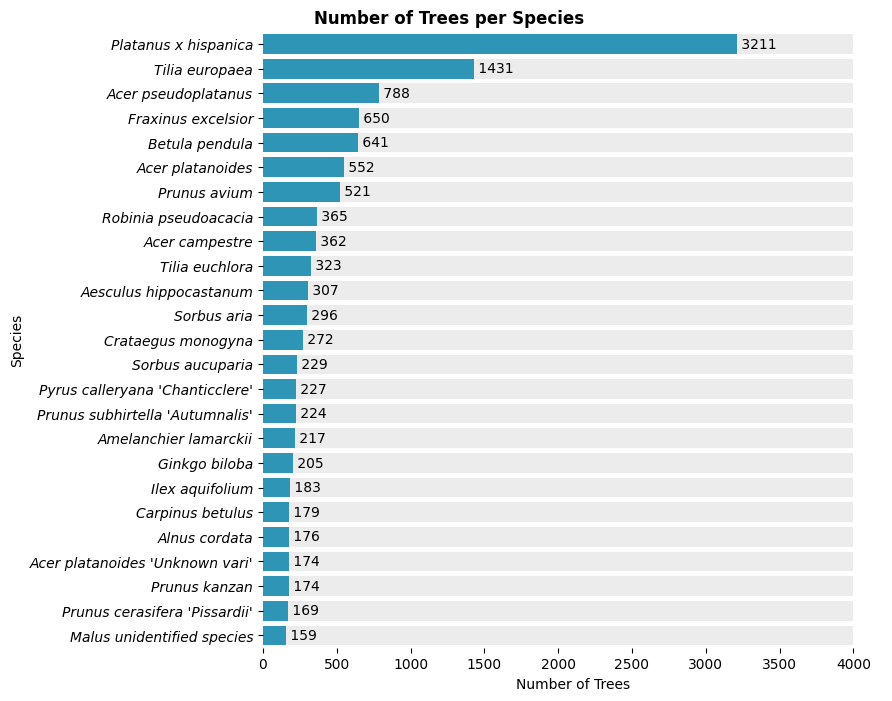

In [16]:
# sort the data by number of trees
top_25_species_summary_sorted = top_25_species_summary.sort_values(by='Number Of Trees', ascending=False)

# define your figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# create a DataFrame that has the maximum value for all species
max_value = 4000
max_df = top_25_species_summary_sorted.copy()
max_df['Number Of Trees'] = max_value

# create a bar plot with light grey bars that represent the maximum possible value
sns.barplot(x='Number Of Trees', y='Scientific Name', data=max_df, color='#ececec', ax=ax)

# create your original bar plot on top of the light grey one
sns.barplot(x='Number Of Trees', y='Scientific Name', data=top_25_species_summary_sorted, color='#18a1cd', ax=ax)

# add the values at the end of the bars
for i, value in enumerate(top_25_species_summary_sorted['Number Of Trees']):
    ax.text(value, i, f' {value:.0f}', va='center')

# set title and labels
title = ax.set_title('Number of Trees per Species', fontsize=12, fontweight='bold')  # Centered title
title.set_position([.3, 0.5])
ax.set_ylabel('Species')
ax.set_xlabel('Number of Trees')

# remove unnecessary borders
sns.despine(bottom=True, right=True, left=True, top=True)
ax.grid(False)

# Adjust the y-axis labels to be italic
plt.yticks(fontstyle='italic')
#plt.savefig('Numberoftrees.png', dpi=300, bbox_inches='tight')
plt.show()


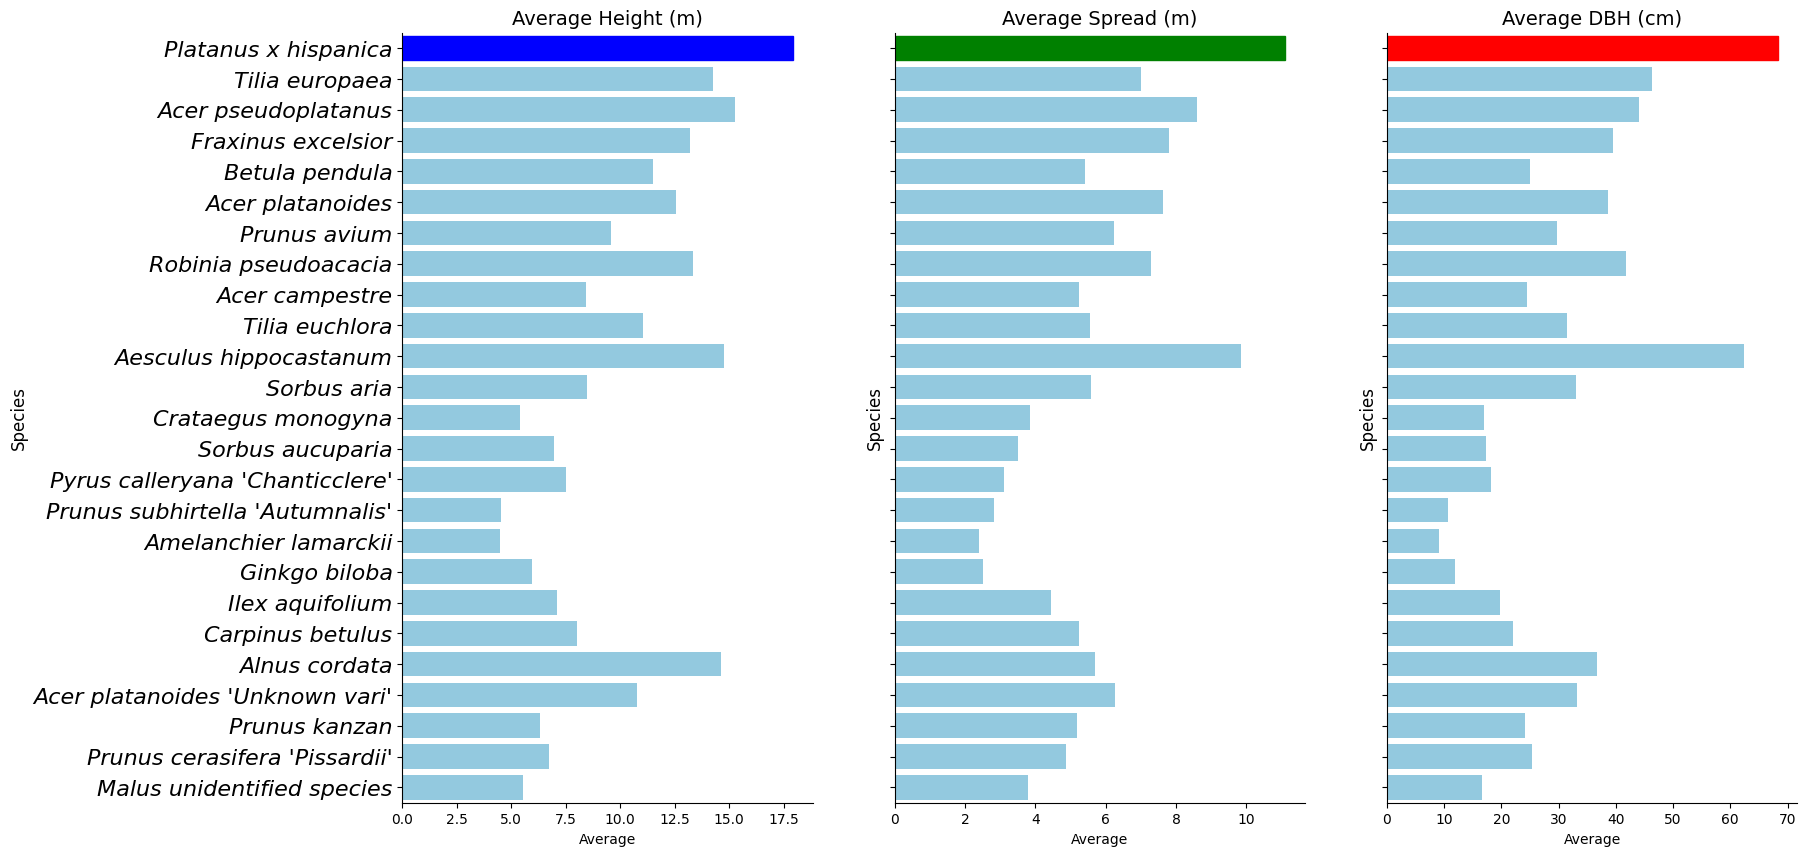

In [17]:
melted_df = top_25_species_summary_sorted.copy()

# create an order dictionary that maps each species to its order
order_dict = {species: i for i, species in enumerate(top_25_species_summary_sorted['Scientific Name'])}
melted_df.drop(columns=['Number Of Trees','Common Name'], inplace=True)

melted_df = pd.melt(melted_df, id_vars='Scientific Name', var_name='Measurement', value_name='Average')

# add a new column to the melted dataframe that represents the order of each species
melted_df['Order'] = melted_df['Scientific Name'].map(order_dict)
melted_df['Average'] = pd.to_numeric(melted_df['Average'], errors='coerce')

height_df = melted_df[melted_df['Measurement'] == 'Average Height (m)']
spread_df = melted_df[melted_df['Measurement'] == 'Average Spread (m)']
dbh_df = melted_df[melted_df['Measurement'] == 'Average DBH (cm)']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 10), sharey=True)

# plot the data for each measurement
sns.barplot(data=height_df, y='Scientific Name', x='Average', ax=axes[0], color="skyblue")
sns.barplot(data=spread_df, y='Scientific Name', x='Average', ax=axes[1], color="skyblue")
sns.barplot(data=dbh_df, y='Scientific Name', x='Average', ax=axes[2], color="skyblue")

# get the index of the species with the highest value for each measurement in the ordered list of species
height_max_idx = height_df['Scientific Name'].tolist().index(height_df.loc[height_df['Average'].idxmax(), 'Scientific Name'])
spread_max_idx = spread_df['Scientific Name'].tolist().index(spread_df.loc[spread_df['Average'].idxmax(), 'Scientific Name'])
dbh_max_idx = dbh_df['Scientific Name'].tolist().index(dbh_df.loc[dbh_df['Average'].idxmax(), 'Scientific Name'])

# highlight the species with the highest value for each measurement
axes[0].patches[height_max_idx].set_color('b')
axes[1].patches[spread_max_idx].set_color('g')
axes[2].patches[dbh_max_idx].set_color('r')

# set the y-axis labels to be italic
plt.setp(axes[0].get_yticklabels(), fontstyle='italic', fontsize=16)
plt.setp(axes[1].get_yticklabels(), fontstyle='italic', fontsize=16)
plt.setp(axes[2].get_yticklabels(), fontstyle='italic', fontsize=16)

# add titles and labels
axes[0].set_title('Average Height (m)',fontsize=14)
axes[1].set_title('Average Spread (m)',fontsize=14)
axes[2].set_title('Average DBH (cm)',fontsize=14)
axes[0].set_ylabel('Species',fontsize=12)
axes[1].set_ylabel('Species',fontsize=12)
axes[2].set_ylabel('Species',fontsize=12)

# remove unnecessary borders
sns.despine(bottom=False, right=True, left=False, top=True)

#plt.savefig('/content/drive/MyDrive/data/3barchart.png', dpi=300, bbox_inches='tight')
plt.show()



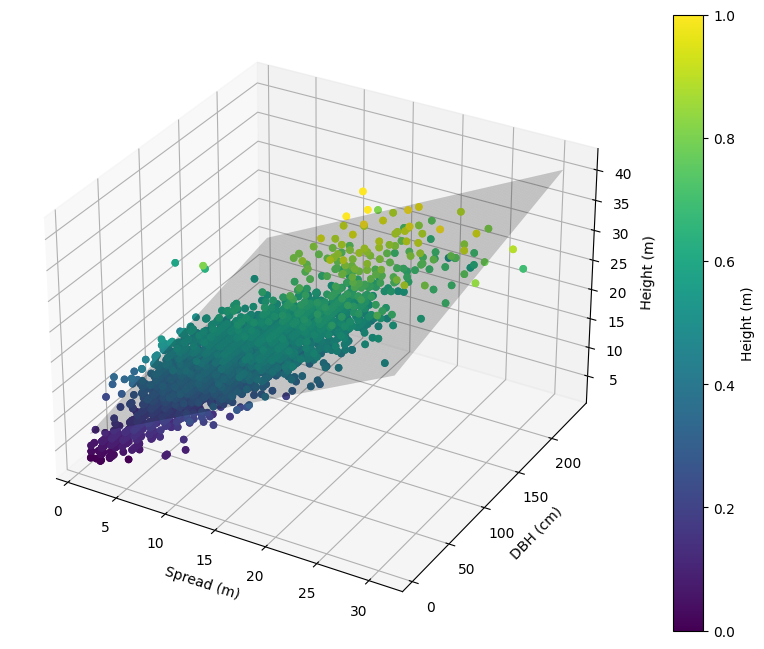

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as sm
from matplotlib import cm

london_plane = filtered_dataset[filtered_dataset['Scientific Name'] == 'Platanus x hispanica']
# rename the columns to replace spaces with underscores
london_plane = london_plane.rename(columns={'Spread In Metres': 'Spread_In_Metres', 'Diameter In Centimetres At Breast Height': 'Diameter_In_Centimetres_At_Breast_Height', 'Height In Metres': 'Height_In_Metres'})

# run the model with the new column names
model = sm.ols(formula='Height_In_Metres ~ Spread_In_Metres + Diameter_In_Centimetres_At_Breast_Height', data = london_plane)
fit = model.fit()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# normalize to [0,1]
norm = plt.Normalize(london_plane['Height_In_Metres'].min(), london_plane['Height_In_Metres'].max())
colors = cm.viridis(norm(london_plane['Height_In_Metres']))

x_surf = np.linspace(london_plane['Spread_In_Metres'].min(), london_plane['Spread_In_Metres'].max(), 100) # generating a range of spread values
y_surf = np.linspace(london_plane['Diameter_In_Centimetres_At_Breast_Height'].min(), london_plane['Diameter_In_Centimetres_At_Breast_Height'].max(), 100) # generating a range of DBH values
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.DataFrame({'Spread_In_Metres': x_surf.ravel(), 'Diameter_In_Centimetres_At_Breast_Height': y_surf.ravel()})
out = fit.predict(exog=exog)
ax.plot_surface(x_surf, y_surf,
                out.values.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha=0.2)

ax.scatter(london_plane['Spread_In_Metres'], london_plane['Diameter_In_Centimetres_At_Breast_Height'], london_plane['Height_In_Metres'],
           c=colors,
           marker='o',
           alpha=1)
sc = ax.scatter(london_plane['Spread_In_Metres'], london_plane['Diameter_In_Centimetres_At_Breast_Height'], london_plane['Height_In_Metres'],
           c=colors,
           marker='o',
           alpha=1)

ax.set_xlabel('Spread (m)')
ax.set_ylabel('DBH (cm)')
ax.set_zlabel('Height (m)')
cbar = fig.colorbar(sc)
cbar.set_label('Height (m)')

#plt.savefig('/content/drive/MyDrive/data/3D_scatterplot.png', dpi=300)
plt.show()



In [19]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Height_In_Metres   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     3460.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:27:36   Log-Likelihood:                -8366.7
No. Observations:                3211   AIC:                         1.674e+04
Df Residuals:                    3208   BIC:                         1.676e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    6.1478      0.153     40.054      0.000       5.847       6.449
Spread_In_Metres                             0.8343      0.020     42.624      0.000       0.796       0.873
Diameter_In_Centimetres_At_Breast_Height     0.0369      0.003     12.536      0.000       0.031       0.043
==============================================================================
Omnibus:                      129.995   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.668
Skew:                           0.447   Prob(JB):                     3.51e-35
Kurtosis:                       3.621   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

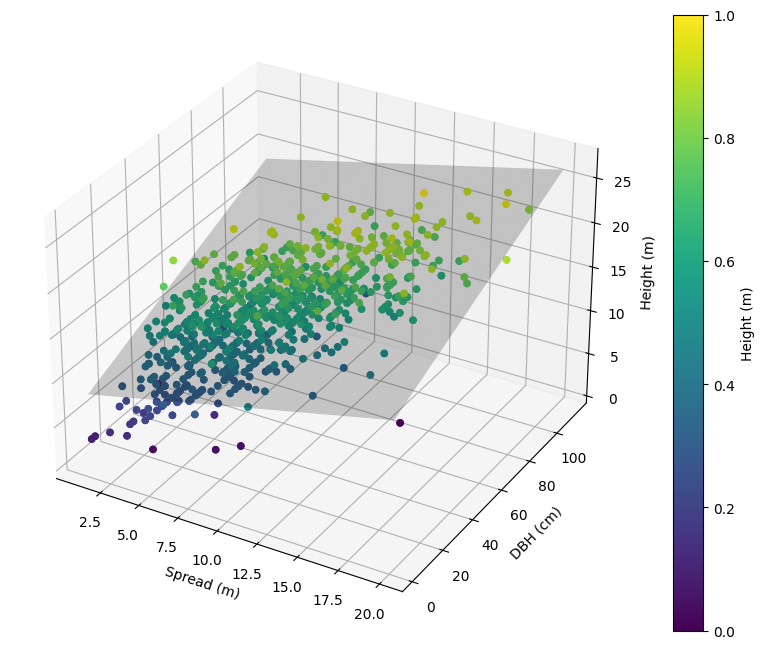

In [20]:
sycamore = filtered_dataset[filtered_dataset['Scientific Name'] == 'Acer pseudoplatanus']

# rename the columns to replace spaces with underscores
sycamore = sycamore.rename(columns={'Spread In Metres': 'Spread_In_Metres', 'Diameter In Centimetres At Breast Height': 'Diameter_In_Centimetres_At_Breast_Height', 'Height In Metres': 'Height_In_Metres'})

# run the model with the new column names
model = sm.ols(formula='Height_In_Metres ~ Spread_In_Metres + Diameter_In_Centimetres_At_Breast_Height', data = sycamore)
fit = model.fit()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# normalize to [0,1]
norm = plt.Normalize(sycamore['Height_In_Metres'].min(), sycamore['Height_In_Metres'].max())
colors = cm.viridis(norm(sycamore['Height_In_Metres']))

x_surf = np.linspace(sycamore['Spread_In_Metres'].min(), sycamore['Spread_In_Metres'].max(), 100) # generating a range of spread values
y_surf = np.linspace(sycamore['Diameter_In_Centimetres_At_Breast_Height'].min(), sycamore['Diameter_In_Centimetres_At_Breast_Height'].max(), 100) # generating a range of DBH values
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

exog = pd.DataFrame({'Spread_In_Metres': x_surf.ravel(), 'Diameter_In_Centimetres_At_Breast_Height': y_surf.ravel()})
out = fit.predict(exog=exog)
ax.plot_surface(x_surf, y_surf,
                out.values.reshape(x_surf.shape),
                rstride=1,
                cstride=1,
                color='None',
                alpha=0.2)

ax.scatter(sycamore['Spread_In_Metres'], sycamore['Diameter_In_Centimetres_At_Breast_Height'], sycamore['Height_In_Metres'],
           c=colors,
           marker='o',
           alpha=1)
sc = ax.scatter(sycamore['Spread_In_Metres'], sycamore['Diameter_In_Centimetres_At_Breast_Height'], sycamore['Height_In_Metres'],
           c=colors,
           marker='o',
           alpha=1)

ax.set_xlabel('Spread (m)')
ax.set_ylabel('DBH (cm)')
ax.set_zlabel('Height (m)')
cbar = fig.colorbar(sc)
cbar.set_label('Height (m)')

#plt.savefig('/content/drive/MyDrive/data/3D_scatterplot2.png', dpi=300)
plt.show()


In [21]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Height_In_Metres   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     291.2
Date:                Thu, 24 Aug 2023   Prob (F-statistic):           2.52e-95
Time:                        20:27:44   Log-Likelihood:                -2052.0
No. Observations:                 788   AIC:                             4110.
Df Residuals:                     785   BIC:                             4124.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    7.7119      0.338     22.815      0.000       7.048       8.375
Spread_In_Metres                             0.3962      0.053      7.506      0.000       0.293       0.500
Diameter_In_Centimetres_At_Breast_Height     0.0943      0.009      9.946      0.000       0.076       0.113
==============================================================================
Omnibus:                       39.300   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.108
Skew:                          -0.336   Prob(JB):                     8.08e-17
Kurtosis:                       4.343   Cond. No.                         141.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Sampling Strategies


> Stratified sampling get 1000 samples -- imbalanced




> Oversampling and Undersampling get 2500 samples -- balanced




In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

# samples in total
n_samples = 1000

# calculate samples per species
samples_per_species = n_samples // len(top_25_species_summary['Scientific Name'].unique())

assert samples_per_species > 0, "Not enough total samples to sample from each species"

# initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=0)

# perform stratified shuffle split. Here we assume the 'Scientific Name' is the label for stratification
for train_index, _ in sss.split(filtered_dataset, filtered_dataset['Scientific Name']):
    sampled_df = filtered_dataset.iloc[train_index]


In [23]:
sampled_df.groupby('Scientific Name').size()


Scientific Name
Acer campestre                      30
Acer platanoides                    46
Acer platanoides 'Unknown vari'     14
Acer pseudoplatanus                 65
Aesculus hippocastanum              26
Alnus cordata                       15
Amelanchier lamarckii               18
Betula pendula                      53
Carpinus betulus                    15
Crataegus monogyna                  23
Fraxinus excelsior                  54
Ginkgo biloba                       17
Ilex aquifolium                     15
Malus unidentified species          13
Platanus x hispanica               267
Prunus avium                        43
Prunus cerasifera 'Pissardii'       14
Prunus kanzan                       14
Prunus subhirtella 'Autumnalis'     19
Pyrus calleryana 'Chanticclere'     19
Robinia pseudoacacia                30
Sorbus aria                         25
Sorbus aucuparia                    19
Tilia euchlora                      27
Tilia europaea                     119
dtype: in

In [24]:
# reset the index of the DataFrame, keeping the old index as a new column
sampled_df = sampled_df.reset_index().rename(columns={"index": "original_index"})

# add a new column 'new_index' that starts from 1 and increment by 1 for each row
sampled_df['new_index'] = range(1, len(sampled_df) + 1)

# set the new column as the index
sampled_df = sampled_df.set_index('new_index')

# sampled_df.to_csv('/content/drive/MyDrive/data/samples.csv')

## *Stratified sampling*


*  sample1000 is 1000 trees filtered from sample_df that can get images from Google street view


In [27]:
# get access to csv file in github
url = 'https://raw.githubusercontent.com/Ddddzq/Tree-Species-Identification-Model/main/sample1000.csv'
response = requests.get(url)

if response.status_code == 200:
    data = StringIO(response.text)
    sampled1000 = pd.read_csv(data)
else:
    print("Failed to fetch the file.")

In [28]:
# index is an important factor to ensure that the image and feature data keep matching
import os

def get_image_path(index):
    return os.path.join('/content/drive/MyDrive/data/sample_image', str(index+1) + '.png')

# Add the 'image_path' column to the DataFrame
sampled1000['image_path'] = sampled1000.index.map(get_image_path)


In [29]:
sampled1000.head()

,new_index,original_index,Contract Area,Number Of Trees,Scientific Name,Common Name,Height In Metres,Spread In Metres,Diameter In Centimetres At Breast Height,Maturity,Longitude,Latitude,Location,image_path
0,1,10249,Parks,1,Tilia europaea,Lime - Common,9.0,3.0,38,Semi-mature,-0.139685,51.543638,"(51.543638, -0.139685)",/content/drive/MyDrive/data/sample_image/1.png
1,2,2737,Highways,1,Platanus x hispanica,London plane,7.0,5.0,20,Early mature,-0.125329,51.534471,"(51.534471, -0.125329)",/content/drive/MyDrive/data/sample_image/2.png
2,3,2810,Highways,1,Tilia euchlora,Lime - Caucasian,9.0,4.0,32,Mature,-0.155590,51.553976,"(51.553976, -0.15559)",/content/drive/MyDrive/data/sample_image/3.png
3,4,5123,Highways,1,Pyrus calleryana 'Chanticclere',Pear - Chanticclere,10.0,6.0,30,Semi-mature,-0.141633,51.536339,"(51.536339, -0.141633)",/content/drive/MyDrive/data/sample_image/4.png
4,5,10680,Highways,1,Tilia euchlora,Lime - Caucasian,12.0,5.0,30,Semi-mature,-0.172350,51.553793,"(51.553793, -0.17235)",/content/drive/MyDrive/data/sample_image/5.png


In [30]:
len(sampled1000['Scientific Name'].unique())

25

In [31]:
sampled1000.groupby('Scientific Name').size()

Scientific Name
Acer campestre                      33
Acer platanoides                    42
Acer platanoides 'Unknown vari'     22
Acer pseudoplatanus                 57
Aesculus hippocastanum              22
Alnus cordata                       15
Amelanchier lamarckii               22
Betula pendula                      51
Carpinus betulus                    14
Crataegus monogyna                   4
Fraxinus excelsior                  47
Ginkgo biloba                       13
Ilex aquifolium                      3
Malus unidentified species           8
Platanus x hispanica               327
Prunus avium                        29
Prunus cerasifera 'Pissardii'       14
Prunus kanzan                       12
Prunus subhirtella 'Autumnalis'     23
Pyrus calleryana 'Chanticclere'     24
Robinia pseudoacacia                24
Sorbus aria                         21
Sorbus aucuparia                    16
Tilia euchlora                      29
Tilia europaea                     128
dtype: in

### *Oversamling and Undersampling*
From here, the following codes and results are for reading only and cannot be run. You can replace your own data and image paths. 2500 images are stored in my google drive. If you want to download and view, please visit [sample2500](https://drive.google.com/drive/folders/1RBLYMoDOpPyAL5kLAqMy5-SQrN4PBhAc?usp=sharing)

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
import random
from math import ceil


augmented_data = []
max_index = sampled1000.index.max() + 1

# calculate the number of augmented samples needed for each species
required_augments = 100 - sampled1000.groupby('Scientific Name').size()

for species, required_count in required_augments.items():
    species_data = sampled1000[sampled1000['Scientific Name'] == species]
    augments_per_sample = ceil(required_count / len(species_data))
    remaining_augments = required_count

    for _, row in species_data.iterrows():
        original_image = Image.open(row['image_path'])

        # generate augments_per_sample number of augments per sample
        for i in range(augments_per_sample):
            augmented_image = datagen.random_transform(np.array(original_image))

            if required_count <= 0:
                break

            new_image_name = str(max_index + 1) + '.png'
            new_image_path = os.path.join('/content/drive/MyDrive/data/sample_image', new_image_name)
            Image.fromarray(augmented_image).save(new_image_path)

            # update data
            new_row = row.copy()
            new_row['image_path'] = new_image_path
            augmented_data.append(new_row)

            max_index += 1
            remaining_augments -= 1


In [ ]:
sampled1000_augmented = pd.concat([sampled1000, pd.DataFrame(augmented_data)], ignore_index=True)

In [ ]:
data_counts = sampled1000_augmented.groupby('Scientific Name').size()

for species, count in data_counts.items():
    if count > 100:
        # get all samples of this species
        species_data = sampled1000_augmented[sampled1000_augmented['Scientific Name'] == species]

        # randomly select samples to remove until reaching 100
        drop_indices = random.sample(list(species_data.index), count - 100)

        for idx in drop_indices:
            path_to_remove = species_data.at[idx, 'image_path']

            if isinstance(path_to_remove, pd.Series):
                print(f"Problematic index: {idx}")
                print(path_to_remove)
                continue

            os.remove(path_to_remove)

        # delete selected samples
        sampled1000_augmented = sampled1000_augmented.drop(drop_indices)

# print the result to verify that the number of each species is 100
print(sampled1000_augmented.groupby('Scientific Name').size())

In [ ]:
# get the counts for each species
data_counts = sampled1000_augmented.groupby('Scientific Name').size()

# iterate over species and their counts
for species, count in data_counts.items():
    if count > 100:
        # get the data for the species
        species_data = sampled1000_augmented[sampled1000_augmented['Scientific Name'] == species]

        # randomly select excess samples to be deleted
        drop_indices = random.sample(list(species_data.index), count - 100)

        # delete the corresponding images
        for idx in drop_indices:
            os.remove(species_data.at[idx, 'image_path'])

        # drop the excess samples from the dataframe
        sampled1000_augmented = sampled1000_augmented.drop(drop_indices)


In [ ]:
sampled1000_augmented.groupby('Scientific Name').size()

Scientific Name
Acer campestre                     100
Acer platanoides                   100
Acer platanoides 'Unknown vari'    100
Acer pseudoplatanus                100
Aesculus hippocastanum             100
Alnus cordata                      100
Amelanchier lamarckii              100
Betula pendula                     100
Carpinus betulus                   100
Crataegus monogyna                 100
Fraxinus excelsior                 100
Ginkgo biloba                      100
Ilex aquifolium                    100
Malus unidentified species         100
Platanus x hispanica               100
Prunus avium                       100
Prunus cerasifera 'Pissardii'      100
Prunus kanzan                      100
Prunus subhirtella 'Autumnalis'    100
Pyrus calleryana 'Chanticclere'    100
Robinia pseudoacacia               100
Sorbus aria                        100
Sorbus aucuparia                   100
Tilia euchlora                     100
Tilia europaea                     100
dtype: in

In [ ]:
#sampled1000_augmented.to_csv('/content/drive/MyDrive/data/sampled1000_augmented.csv')

# Split dataset into train, valid, and test set

In [33]:
# get access to csv file in github
url = 'https://raw.githubusercontent.com/Ddddzq/Tree-Species-Identification-Model/main/sampled1000_augmented.csv'
response = requests.get(url)

if response.status_code == 200:
    data = StringIO(response.text)
    sampled1000_augmented = pd.read_csv(data)
else:
    print("Failed to fetch the file.")

In [34]:
sampled1000_augmented.head()

,new_index,original_index,Contract Area,Number Of Trees,Scientific Name,Common Name,Height In Metres,Spread In Metres,Diameter In Centimetres At Breast Height,Maturity,Longitude,Latitude,Location,image_path
0,13.0,5085,Parks,1,Acer campestre,Maple - Field,5.0,3.0,9.0,Semi-mature,-0.134169,51.540709,"(51.540709, -0.134169)",/content/drive/MyDrive/data/sample_image/13.png
1,27.0,7019,Housing,1,Acer campestre,Maple - Field,4.0,4.0,14.0,Semi-mature,-0.138788,51.536495,"(51.536495, -0.138788)",/content/drive/MyDrive/data/sample_image/27.png
2,46.0,12962,Highways,1,Acer campestre,Maple - Field,9.0,5.0,22.0,Semi-mature,-0.139095,51.522770,"(51.52277, -0.139095)",/content/drive/MyDrive/data/sample_image/46.png
3,47.0,15981,Housing,1,Acer campestre,Maple - Field,5.0,3.0,10.0,Semi-mature,-0.163799,51.552135,"(51.552135, -0.163799)",/content/drive/MyDrive/data/sample_image/47.png
4,75.0,5627,Highways,1,Acer campestre,Maple - Field,10.0,5.0,21.0,Semi-mature,-0.135244,51.519522,"(51.519522, -0.135244)",/content/drive/MyDrive/data/sample_image/75.png


In [35]:
from sklearn.model_selection import train_test_split

# Assuming 'sampled1000' is your full DataFrame
full_data = sampled1000_augmented

# First, split the data into training+validation set and testing set
train_valid_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42, stratify=full_data['Scientific Name'])

# Then split the training+validation set into separate training and validation sets
train_data, valid_data = train_test_split(train_valid_data, test_size=0.25, random_state=42, stratify=train_valid_data['Scientific Name'])


# Modelling
From here, the following codes and results are for reading only and cannot be run. However, the modelling architecture is completed

### *ResNet50*
The process of adapting a pre-trained model to a new task is often called transfer learning.

> Taking the pre-trained model and use it
as a fixed feature extractor. I remove the last layer (the classification layer) and replaced it with several layers that match the number of classes 25. Only train these new layers on my dataset, while the weights of the original network are kept frozen.



In [ ]:
from PIL import Image
import os

directory = "/content/drive/MyDrive/data/sample_image/"

# Iterate over all files in the directory
for filename in os.listdir(directory):
    # Check if the file is an image (you can modify this to match your filenames)
    if filename.endswith(".png"):
        try:
            # Try to open the image
            img = Image.open(os.path.join(directory, filename))
            img.verify()  # Verify that it is, in fact, an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)  # Print out the names of corrupt files


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


# create a data generator that includes the ResNet50 preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/drive/MyDrive/data/sample_image/',
    x_col='image_path',
    y_col='Scientific Name',
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,
    class_mode='categorical')

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_data,
    directory='/content/drive/MyDrive/data/sample_image/',
    x_col='image_path',
    y_col='Scientific Name',
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,
    class_mode='categorical')

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/drive/MyDrive/data/sample_image/',
    x_col='image_path',
    y_col='Scientific Name',
    target_size=(224, 224),  # resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # don't shuffle test data

Found 1500 validated image filenames belonging to 25 classes.
Found 500 validated image filenames belonging to 25 classes.
Found 500 validated image filenames belonging to 25 classes.


In [ ]:
x_batch, y_batch = next(train_generator)
print('x_batch shape:', x_batch.shape)
print('y_batch shape:', y_batch.shape)

x_batch shape: (32, 224, 224, 3)
y_batch shape: (32, 25)


#### Resnet50 architecture

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# load the ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# additional fully-connected layer
x = Dense(1024, activation='relu')(x)

# and a logistic layer for our number of classes
predictions = Dense(25, activation='softmax')(x)

# this is the model we will train
resnet50_model = Model(inputs=base_model.input, outputs=predictions)

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model with a lower learning rate
resnet50_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# print the resnet50 architecture
resnet50_model.summary()


94765736/94765736 [==============================] - 0s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# fit the model with EarlyStopping
history = resnet50_model.fit(
    train_generator,
    epochs=20,  # increase the number of epochs to 20
    validation_data=valid_generator,
    callbacks=[early_stopping]
)


Epoch 1/20
47/47 [==============================] - 893s 19s/step - loss: 3.0411 - accuracy: 0.2207 - val_loss: 2.3073 - val_accuracy: 0.3340
Epoch 2/20
47/47 [==============================] - 509s 11s/step - loss: 1.6464 - accuracy: 0.5127 - val_loss: 1.9273 - val_accuracy: 0.4360
Epoch 3/20
47/47 [==============================] - 506s 11s/step - loss: 1.0535 - accuracy: 0.7093 - val_loss: 1.7093 - val_accuracy: 0.5000
Epoch 4/20
47/47 [==============================] - 504s 11s/step - loss: 0.6554 - accuracy: 0.8340 - val_loss: 1.5814 - val_accuracy: 0.5620
Epoch 5/20
47/47 [==============================] - 511s 11s/step - loss: 0.4094 - accuracy: 0.9140 - val_loss: 1.5355 - val_accuracy: 0.5480
Epoch 6/20
47/47 [==============================] - 523s 11s/step - loss: 0.2238 - accuracy: 0.9700 - val_loss: 1.5085 - val_accuracy: 0.5640
Epoch 7/20
47/47 [==============================] - 507s 11s/step - loss: 0.1361 - accuracy: 0.9927 - val_loss: 1.4130 - val_accuracy: 0.6140
Epoch 

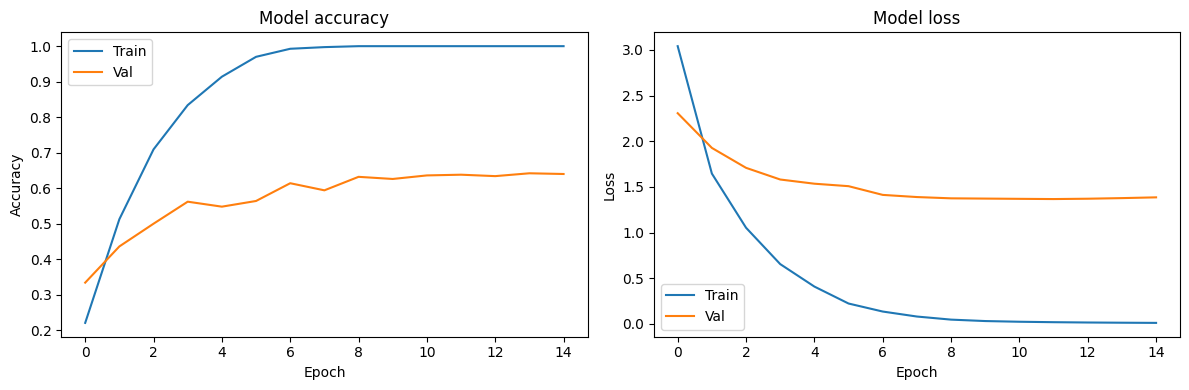

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/model_accuracy_loss.png', dpi=300)
plt.show()


In [ ]:
# Evaluate the model
test_loss, test_acc = resnet50_model.evaluate(test_generator,steps = len(test_data) // 32)

print(f'Test accuracy: {test_acc}')


15/15 [==============================] - 203s 14s/step - loss: 1.3989 - accuracy: 0.6438
Test accuracy: 0.643750011920929


### *XGBoost*
#### Preprocessing

In [36]:
# for structured data
train_structured = train_data.drop(columns=['Number Of Trees','Longitude', 'Latitude','image_path','Contract Area', 'Common Name', 'Location','new_index','original_index'])
valid_structured = valid_data.drop(columns=['Number Of Trees','Longitude', 'Latitude','image_path','Contract Area', 'Common Name', 'Location','new_index','original_index'])
test_structured = test_data.drop(columns=['Number Of Trees','Longitude', 'Latitude','Contract Area', 'Common Name', 'Location','new_index','original_index','image_path'])

In [37]:
from sklearn.preprocessing import LabelEncoder

# initialize the encoder
encoder = LabelEncoder()

# fit and transform the "Maturity" column in the training data
train_structured['Maturity'] = encoder.fit_transform(train_structured['Maturity'])

# transform the "Maturity" column in the validation and test data
valid_structured['Maturity'] = encoder.transform(valid_structured['Maturity'])
test_structured['Maturity'] = encoder.transform(test_structured['Maturity'])


In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# specify target variable and features
target = 'Scientific Name'
features = train_structured.columns.drop(target)

# initialize the encoder
encoder = LabelEncoder()

# fit and transform the "Scientific Name" column in the training data
train_structured['Scientific Name'] = encoder.fit_transform(train_structured['Scientific Name'])

# transform the "Scientific Name" column in the validation and test data
valid_structured['Scientific Name'] = encoder.transform(valid_structured['Scientific Name'])
test_structured['Scientific Name'] = encoder.transform(test_structured['Scientific Name'])


#### Trainging

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgb_classifier = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
param_grid = {
    'learning_rate': [0.005, 0.01, 0.02],
    'max_depth': [5, 6, 7],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'min_child_weight': [10, 12, 14],
    'subsample': [0.8, 0.85, 0.9],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(train_structured[features], train_structured[target])

print("Best parameters found: ", grid_search.best_params_)

valid_predictions = grid_search.predict(valid_structured[features])
accuracy = accuracy_score(valid_structured[target], valid_predictions)
print("Validation accuracy: ", accuracy)

test_predictions = grid_search.predict(test_structured[features])


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, subsample=0.85; total time=   0.5s
[CV] END colsample_bytree=0.4, learning_rate=0.005, max_depth=5, min_child_weight=10, n_estimators=100, sub

In [ ]:
test_predictions

array([ 3, 18, 22, 23,  0,  6,  3, 17, 12,  3, 24, 23, 19,  2,  9, 24, 22,
        9, 15, 17, 17, 14,  9, 18, 16,  2, 11, 16, 23, 23,  6, 16, 14,  7,
       22,  6, 18,  1,  0, 11, 11, 22, 16, 23, 19, 14, 19, 23, 24,  2,  0,
        2,  6, 11, 21,  7,  0,  1,  9, 20, 20,  0,  0,  7, 16, 13,  1,  3,
        2,  9, 19, 22, 24, 10, 23,  3, 16, 22, 21, 14, 18, 19, 18,  1,  9,
        7,  3, 18, 16,  3, 11, 23, 16, 16, 16, 11, 17, 20, 21, 18,  0, 14,
       21, 14,  6, 18, 17,  2, 14, 18,  9,  0, 14,  6, 23, 16, 11,  3, 24,
        3, 16, 24,  3, 23,  3, 18,  6, 23,  4, 11, 19, 22, 19, 11, 18,  7,
       23, 18, 24,  1, 22, 15, 14, 22, 24, 12, 21, 12, 23,  4, 18, 23, 21,
       21, 24, 12, 21, 14, 16, 24,  9, 17,  1, 18, 14, 19, 15, 18, 16, 16,
       22, 10,  1, 18, 18,  9, 24,  2,  9, 10,  1, 23,  2,  1,  3, 11, 23,
       17, 14, 19, 11, 14,  3,  0,  6, 15, 16,  9, 22, 22, 17, 11,  6,  9,
       24, 23, 24,  7, 19,  6,  7, 14,  7,  1,  7, 13, 22, 18, 20,  3,  9,
       10, 11, 14,  6, 21

In [ ]:
eval_set = [(train_structured[features], train_structured[target]),(valid_structured[features], valid_structured[target])]
grid_search.best_estimator_.fit(train_structured[features], train_structured[target], early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)

test_predictions = grid_search.predict(test_structured[features])
test_accuracy = accuracy_score(test_structured[target], test_predictions)
print("Test accuracy: ", test_accuracy)


[0]	validation_0-mlogloss:3.20703	validation_1-mlogloss:3.20886
[1]	validation_0-mlogloss:3.19675	validation_1-mlogloss:3.20038
[2]	validation_0-mlogloss:3.18555	validation_1-mlogloss:3.19065
[3]	validation_0-mlogloss:3.17499	validation_1-mlogloss:3.18195
[4]	validation_0-mlogloss:3.16299	validation_1-mlogloss:3.17155
[5]	validation_0-mlogloss:3.15193	validation_1-mlogloss:3.16213
[6]	validation_0-mlogloss:3.14123	validation_1-mlogloss:3.15325
[7]	validation_0-mlogloss:3.13249	validation_1-mlogloss:3.14596
[8]	validation_0-mlogloss:3.12229	validation_1-mlogloss:3.13756
[9]	validation_0-mlogloss:3.11169	validation_1-mlogloss:3.12821
[10]	validation_0-mlogloss:3.10111	validation_1-mlogloss:3.11941
[11]	validation_0-mlogloss:3.09055	validation_1-mlogloss:3.10990
[12]	validation_0-mlogloss:3.08070	validation_1-mlogloss:3.10162
[13]	validation_0-mlogloss:3.07158	validation_1-mlogloss:3.09405
[14]	validation_0-mlogloss:3.06283	validation_1-mlogloss:3.08698
[15]	validation_0-mlogloss:3.05382	

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[18]	validation_0-mlogloss:3.02864	validation_1-mlogloss:3.05739
[19]	validation_0-mlogloss:3.01994	validation_1-mlogloss:3.05008
[20]	validation_0-mlogloss:3.01268	validation_1-mlogloss:3.04392
[21]	validation_0-mlogloss:3.00473	validation_1-mlogloss:3.03722
[22]	validation_0-mlogloss:2.99620	validation_1-mlogloss:3.03004
[23]	validation_0-mlogloss:2.98846	validation_1-mlogloss:3.02362
[24]	validation_0-mlogloss:2.98046	validation_1-mlogloss:3.01648
[25]	validation_0-mlogloss:2.97296	validation_1-mlogloss:3.01006
[26]	validation_0-mlogloss:2.96582	validation_1-mlogloss:3.00445
[27]	validation_0-mlogloss:2.95832	validation_1-mlogloss:2.99827
[28]	validation_0-mlogloss:2.95174	validation_1-mlogloss:2.99259
[29]	validation_0-mlogloss:2.94457	validation_1-mlogloss:2.98639
[30]	validation_0-mlogloss:2.93689	validation_1-mlogloss:2.98049
[31]	validation_0-mlogloss:2.92951	validation_1-mlogloss:2.97419
[32]	validation_0-mlogloss:2.92201	validation_1-mlogloss:2.96781
[33]	validation_0-mloglos

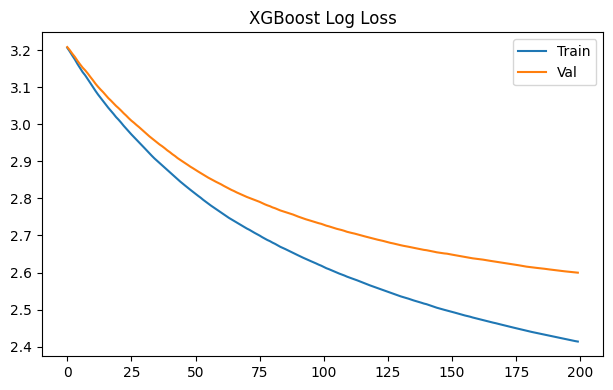

In [ ]:
results = grid_search.best_estimator_.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
plt.title('XGBoost Log Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/xgboost_loss.png', dpi=300)
plt.show()


### *Final layer*

In [ ]:
import math

# calculate the number of steps (batches) to include all samples
steps = math.ceil(len(test_data) / 32)

# generate predictions for all samples
resnet50_output = resnet50_model.predict(test_generator, steps=steps)
xgb_output = test_predictions

16/16 [==============================] - 133s 8s/step


In [ ]:
xgb_output = xgb_output.astype('float32')
resnet50_output = resnet50_output.reshape(resnet50_output.shape[0], -1)
xgb_output = xgb_output.reshape(xgb_output.shape[0], -1)

In [ ]:
print(resnet50_output.shape)
print(xgb_output.shape)


(500, 25)
(500, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from keras.utils import to_categorical

# Combine the outputs
combined = Concatenate(axis=1)([resnet50_output, xgb_output])

# Create a new model
final_model = Sequential()
final_model.add(Dense(512, activation='relu', input_shape=(combined.shape[1],)))
final_model.add(Dense(256, activation='relu'))
final_model.add(Dense(25, activation='softmax'))  # have 25 classes

# Compile the model
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

labels = to_categorical(test_structured['Scientific Name'])
# Train the model
history_final=final_model.fit(combined, labels, epochs=25, validation_split=0.2,callbacks = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

)


Epoch 1/25
13/13 [==============================] - 3s 43ms/step - loss: 3.3672 - accuracy: 0.0525 - val_loss: 3.2984 - val_accuracy: 0.1000
Epoch 2/25
13/13 [==============================] - 0s 14ms/step - loss: 3.2143 - accuracy: 0.1100 - val_loss: 3.1219 - val_accuracy: 0.1000
Epoch 3/25
13/13 [==============================] - 0s 17ms/step - loss: 3.1185 - accuracy: 0.2000 - val_loss: 3.1144 - val_accuracy: 0.1500
Epoch 4/25
13/13 [==============================] - 0s 15ms/step - loss: 3.0036 - accuracy: 0.2850 - val_loss: 3.0230 - val_accuracy: 0.3300
Epoch 5/25
13/13 [==============================] - 0s 18ms/step - loss: 2.8853 - accuracy: 0.3950 - val_loss: 2.8676 - val_accuracy: 0.4200
Epoch 6/25
13/13 [==============================] - 0s 16ms/step - loss: 2.7092 - accuracy: 0.5050 - val_loss: 2.6939 - val_accuracy: 0.5300
Epoch 7/25
13/13 [==============================] - 0s 17ms/step - loss: 2.4996 - accuracy: 0.5500 - val_loss: 2.5419 - val_accuracy: 0.5300
Epoch 8/25
13

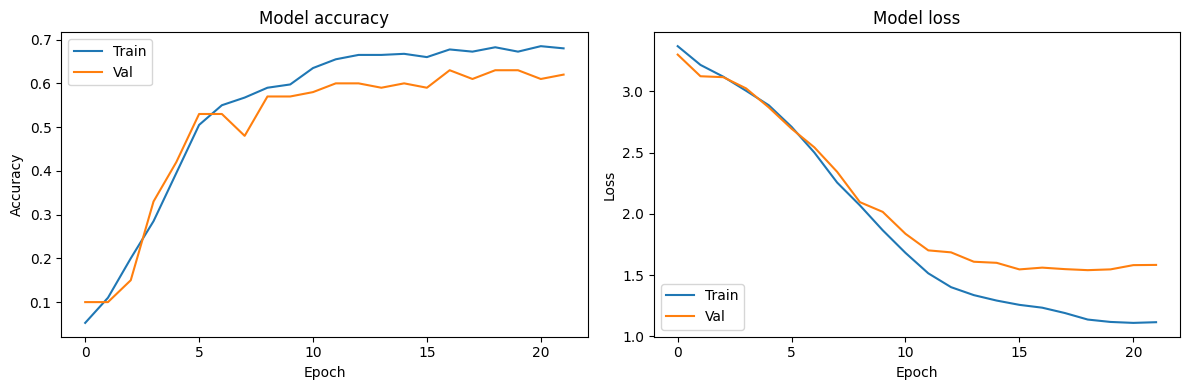

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower left')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/data/model_accuracy_loss_final.png', dpi=300)
plt.show()


In [ ]:
# Evaluate the model on the test set
loss, accuracy = final_model.evaluate(combined, labels)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

16/16 [==============================] - 0s 2ms/step - loss: 1.1428 - accuracy: 0.6760
Test Loss:  1.1428134441375732
Test Accuracy:  0.6759999990463257


# Model Evaluation
### *Cofusion Matrix*

16/16 [==============================] - 0s 2ms/step


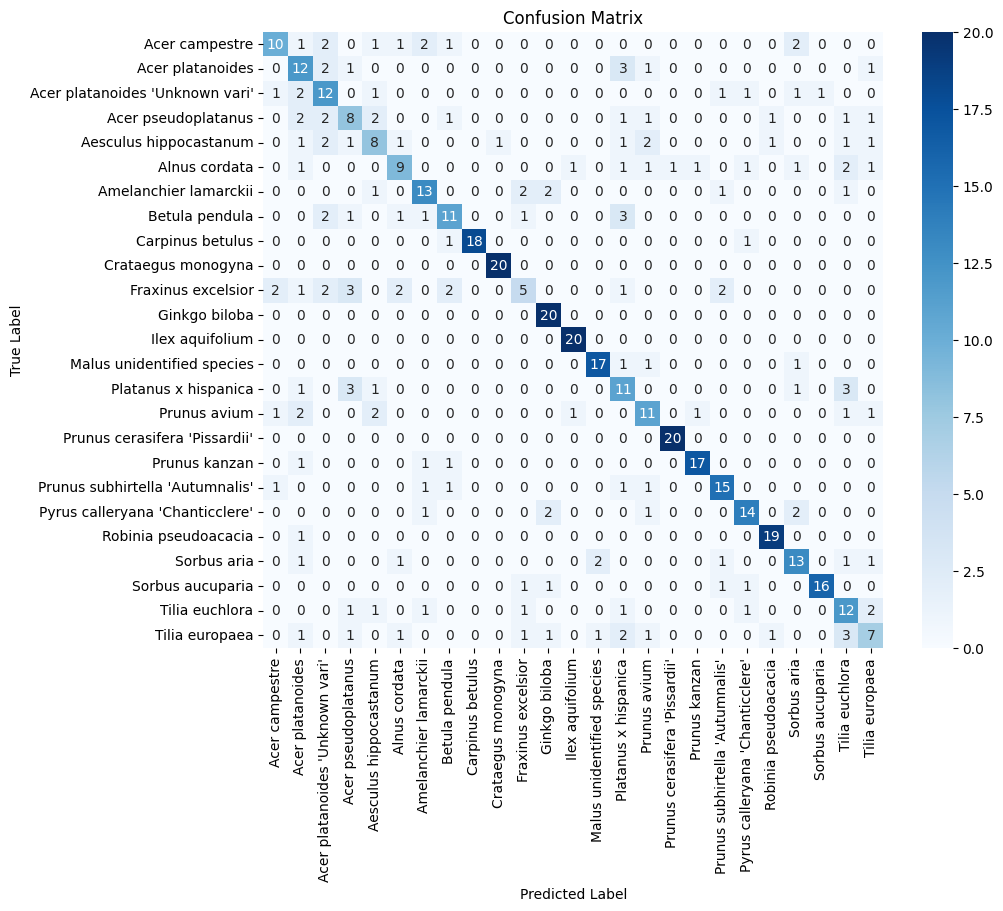

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the predictions from the model
y_pred = final_model.predict(combined)
# Choose the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Similarly, choose the actual class for each sample from one-hot encoded labels
y_true = np.argmax(labels, axis=1)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Get the species names from the LabelEncoder
species_names = encoder.inverse_transform(range(25))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=species_names, yticklabels=species_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### *Precision Recall F1 Table*


In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

predictions = final_model.predict(combined)

predicted_classes = predictions.argmax(axis=1)
true_classes = test_structured['Scientific Name'].values

precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average=None)


class_names = list(test_structured['Scientific Name'].unique())
results_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

print(results_df)


16/16 [==============================] - 0s 2ms/step
    Class  Precision  Recall  F1 Score
0       3   0.666667    0.50  0.571429
1      22   0.444444    0.60  0.510638
2      23   0.500000    0.60  0.545455
3      17   0.421053    0.40  0.410256
4      18   0.470588    0.40  0.432432
5      11   0.562500    0.45  0.500000
6       0   0.650000    0.65  0.650000
7       2   0.611111    0.55  0.578947
8      20   1.000000    0.90  0.947368
9      21   0.952381    1.00  0.975610
10      1   0.454545    0.25  0.322581
11     16   0.769231    1.00  0.869565
12     12   0.909091    1.00  0.952381
13      9   0.850000    0.85  0.850000
14      4   0.423077    0.55  0.478261
15     13   0.550000    0.55  0.550000
16      6   0.952381    1.00  0.975610
17     10   0.894737    0.85  0.871795
18     24   0.714286    0.75  0.731707
19     15   0.736842    0.70  0.717949
20     19   0.863636    0.95  0.904762
21      8   0.619048    0.65  0.634146
22      7   0.941176    0.80  0.864865
23      5  

In [ ]:
#results_df.to_csv('/content/drive/MyDrive/data/Precision_recall_f1.csv')